# Preprocessing and Training <a id='Preprocessing_and_Training'></a>

### 1 Table of Contents<a id='Contents'></a>
* [Preprocessing and Training](#Preprocessing_and_Training)
  * [1 Contents](#Contents)
  * [2 Introduction](#2_Introduction)
      * [2.1 Recap](#2.1_Recap)
      * [2.2 Next Steps](#2.2_Next_Steps)
  * [3 Imports](#3_Imports)
  * [4 Load Data](#4_Load_Data)
  * [5 State of Data](#4_State_of_Data)
      * [5.1 Outliers](#5.1_Outliers)
      * [5.2 Dummy Variable or Drop Column](#5.2_Dummy_Variable_or_Drop_Column)
      * [5.3 Scaling](#5.3_Scaling)
  * [6 Split Data](#6_Split_Data)
  * [7 Save Data](#7_Save_Data)
  * [8 Conclusion](#8_Conclusion)  

### 2 Introduction<a id='2_Introduction'></a>

#### 2.1 Recap<a id='2.1_Recap'></a>

In the last step, we did some deep dives on our features. We started by scaling down the power data from ForestRoad and Maple Drive East because their installations where much bigger than YMCA's and would result in confusing our model. We then looked at the correlations between our variables. Most of our features are correlated with eachother, which can be expected when discussing weather. We also looked at the relationship between our features and our targer variable. Clear relationships were not able to be gained from these plots. However, when we created plots of combinations of variables, the relationships started to show themselves. Lastly, we looked at our target variable. Forest Road had a lot of outliers but their existence is supported by the large number of outliers in the other feature columns for that site.

#### 2.2 Next Steps<a id='2.2_Next_Steps'></a>

In this notebook, we will prepare our dataset for modeling. Our features are very correlated so we will perform PCA to make them independent of one another, and possibly reduce the dimensions. We will then split the data into a training and testing set. We will also set up a baseline model, the mean, to test our future model's against. Let's go!

### 3 Imports<a id='3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from library.sb_utils import save_file

### 4 Load Data<a id='4_Load_Data'></a>

In [2]:
UK_data = pd.read_csv('../data/UK_data.csv')

In [3]:
UK_data.head()

,Unnamed: 0,Site,TempOut,OutHum,DewPt,WindSpeed,WindRun,WindChill,HeatIndex,THWIndex,Bar,Rain,RainRate,SolarRad,SolarEnergy,P_GEN,Temp_Pressure_ratio,Humidity_Radiation_ratio
0,0,YMCA,14.1,91.0,12.6,0,0.0,14.1,14.1,14.1,755.5,0.0,0.0,11.0,0.47,0.014,0.018663,8.272727
1,1,YMCA,14.1,91.0,12.7,0,0.0,14.1,14.2,14.2,755.5,0.0,0.0,23.0,0.99,0.067,0.018663,3.956522
2,2,YMCA,14.4,91.0,12.9,0,0.0,14.4,14.4,14.4,755.7,0.0,0.0,34.0,1.46,0.216,0.019055,2.676471
3,3,YMCA,15.1,86.0,12.7,0,0.0,15.1,15.1,15.1,755.8,0.0,0.0,57.0,2.45,0.256,0.019979,1.508772
4,4,YMCA,16.0,77.0,12.0,0,0.0,16.0,15.9,15.9,756.2,0.0,0.0,56.0,2.41,0.284,0.021158,1.375000


In [4]:
UK_data.set_index('Unnamed: 0', inplace = True)

In [5]:
UK_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11846 entries, 0 to 11845
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Site                      11846 non-null  object 
 1   TempOut                   11846 non-null  float64
 2   OutHum                    11846 non-null  float64
 3   DewPt                     11846 non-null  float64
 4   WindSpeed                 11846 non-null  int64  
 5   WindRun                   11846 non-null  float64
 6   WindChill                 11846 non-null  float64
 7   HeatIndex                 11846 non-null  float64
 8   THWIndex                  11846 non-null  float64
 9   Bar                       11846 non-null  float64
 10  Rain                      11846 non-null  float64
 11  RainRate                  11846 non-null  float64
 12  SolarRad                  11846 non-null  float64
 13  SolarEnergy               11846 non-null  float64
 14  P_GEN 

### 5 State of the Data<a id='5_State_of_the_Data'></a>

#### 5.1 Outliers<a id='5.1_Outliers'></a>

In the last notebook, I looked at the outliers in the P_GEN column for the different sites. I am going to look at those outliers more closely now. I need to find out weather they are legitimate measurements or some sort of error. Let's start with a boxplot.

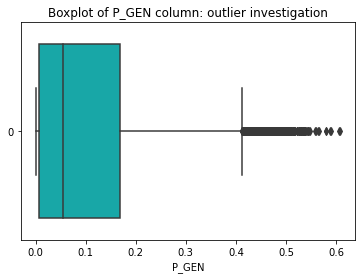

In [6]:
fig, ax = plt.subplots(figsize = (6, 4))
sns.boxplot(data=UK_data['P_GEN'], orient = 'h', color = 'c')
ax.set_xlabel('P_GEN')
ax.set_title('Boxplot of P_GEN column: outlier investigation');

Let's look at some summary statistics for that column

In [7]:
UK_data['P_GEN'].describe()

count    11846.000000
mean         0.107457
std          0.127561
min          0.000000
25%          0.006000
50%          0.054000
75%          0.168251
max          0.608460
Name: P_GEN, dtype: float64

I want to know how many values are more than three standard deviations above the mean, since all of our outliers are on the high end.

In [8]:
mean = UK_data['P_GEN'].mean()
std = UK_data['P_GEN'].std()

Outliers = UK_data[UK_data['P_GEN'] > (mean + 3 * std)]
Outliers['P_GEN'].info()

<class 'pandas.core.series.Series'>
Int64Index: 125 entries, 3752 to 9887
Series name: P_GEN
Non-Null Count  Dtype  
--------------  -----  
125 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


There are 125 values that are more than three standard deviations away from the mean. Let's look at the boxplots for the other variables, as well

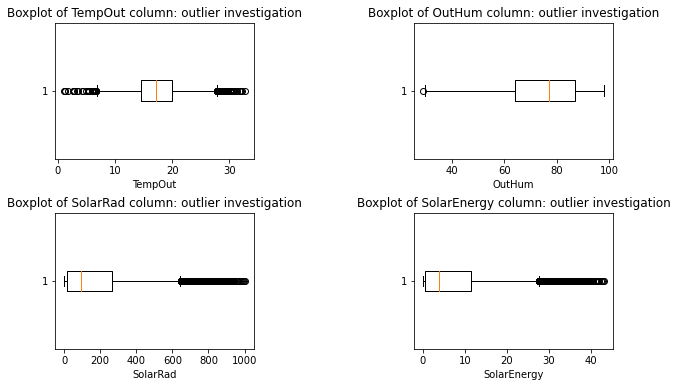

In [9]:
fig, ax = plt.subplots(2, 2, figsize = (10, 6))
fig.subplots_adjust(wspace = 0.8, hspace = 0.4)
ax[0, 0].boxplot(UK_data['TempOut'], vert = False)
ax[0, 0].set_xlabel('TempOut')
ax[0, 0].set_title('Boxplot of TempOut column: outlier investigation')
ax[0, 1].boxplot(UK_data['OutHum'], vert = False)
ax[0, 1].set_xlabel('OutHum')
ax[0, 1].set_title('Boxplot of OutHum column: outlier investigation');
ax[1, 0].boxplot(UK_data['SolarRad'], vert = False)
ax[1, 0].set_xlabel('SolarRad')
ax[1, 0].set_title('Boxplot of SolarRad column: outlier investigation')
ax[1, 1].boxplot(UK_data['SolarEnergy'], vert = False)
ax[1, 1].set_xlabel('SolarEnergy')
ax[1, 1].set_title('Boxplot of SolarEnergy column: outlier investigation');

Most notably, solar radiation and solar energy have really high amounts of outliers; Temperature does too. The consistency in outliers across the different features and target variable leads me to believe that these are valid measurements that come from days that were particularly good for generating solar power. We will leave these outliers as part of our data

#### 5.2 Dummy Variable or Drop Column<a id='5.2_Dummy_Variable_or_Drop_Column'></a>

As can be see from the info() call after loading the data, most of our features are floats or ints. However, one feature, Site, is categorical. We could create a dummy variable for this feature. Our model does not need the site information, though. So, instead we will drop this column now and take the dataset as a whole. No other features make since for dummy variables

In [10]:
UK_data.drop(columns = 'Site', inplace = True)

#### 5.3 Scaling <a id='5.3_Scaling'></a>

Let's talk about scaling our data. Scaling is a requirement of many different models. Our variables are heavily dependent on each other. Therfore, PCA would be a good choice for our data and that would require scaled data. However, I am not sure that it well be the best option to rush and do that now. I prefer to wait on tackling scaling until we start modeling so that I can use gridsearchcv to figure out if it's presence is helpful or not. This will be seen in the following notebook.

### 6 Split the Data<a id='6_Split_the_Data'></a>

Our data is now ready to split into test and train data. We will be doing a 75/25 train/test split. First, we need to make x and y variables

In [11]:
x = UK_data.drop(columns = 'P_GEN')
y = UK_data['P_GEN']

Now, I'll use sklearn's train_test_split to create our new train and test variables.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [13]:
x_train.head()

,TempOut,OutHum,DewPt,WindSpeed,WindRun,WindChill,HeatIndex,THWIndex,Bar,Rain,RainRate,SolarRad,SolarEnergy,Temp_Pressure_ratio,Humidity_Radiation_ratio
Unnamed: 0,,,,,,,,,,,,,,,
10495,15.6,91.0,14.1,1,0.5,15.6,15.7,15.7,759.2,0.0,0.0,0.0,0.00,0.020548,inf
10194,16.9,82.0,13.8,3,1.5,16.9,17.1,17.1,756.9,0.0,0.0,0.0,0.00,0.022328,inf
7603,15.6,69.0,9.9,1,0.5,15.6,15.2,15.2,755.2,0.0,0.0,0.0,0.00,0.020657,inf
6655,13.1,77.0,9.2,2,1.0,13.1,12.8,12.8,767.5,0.0,0.0,0.0,0.00,0.017068,inf
2089,17.3,52.0,7.4,1,0.5,17.3,16.4,16.4,758.0,0.0,0.0,556.0,23.91,0.022823,0.093525


Great! Let's move onto creating our pipeline for future modeling.

In [14]:
x_test.head()

,TempOut,OutHum,DewPt,WindSpeed,WindRun,WindChill,HeatIndex,THWIndex,Bar,Rain,RainRate,SolarRad,SolarEnergy,Temp_Pressure_ratio,Humidity_Radiation_ratio
Unnamed: 0,,,,,,,,,,,,,,,
9449,17.8,71.0,12.4,2,1.0,17.8,17.7,17.7,754.4,0.0,0.0,548.0,23.57,0.023595,0.129562
3719,12.4,82.0,9.5,0,0.0,12.4,12.3,12.3,751.0,0.0,0.0,170.0,7.31,0.016511,0.482353
11609,20.9,73.0,15.9,0,0.0,20.9,21.2,21.2,763.5,0.0,0.0,176.0,7.57,0.027374,0.414773
8416,21.3,63.0,14.0,1,0.5,21.3,21.1,21.1,761.3,0.0,0.0,0.0,0.00,0.027978,inf
1693,18.9,66.0,12.4,3,1.5,18.9,18.8,18.8,750.5,0.0,0.0,717.0,30.84,0.025183,0.092050


### 8 Save Data<a id='8_Save_Data'></a>

In [15]:
datapath = '../data'
save_file(x_train, 'X_train.csv', datapath)
save_file(x_test, 'X_test.csv', datapath)
save_file(y_train, 'Y_train.csv', datapath)
save_file(y_test, 'Y_test.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data/X_train.csv"
A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data/X_test.csv"
A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data/Y_train.csv"
A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data/Y_test.csv"


### 9 Conclusion<a id='9_Conclusion'></a>

In this notebook, I looked at the outliers present in our data. We do see a lot of outliers. However, they are consistent so I believe that they are valid measurements. We dropped our the 'Site' column from our data and determined whether any other variables needed dummy variables. I also considered scaling the data. I decided to hold off until the modeling stage to determine its effectiveness using cross validation.

Finally, we split our data in dependent and independent variables. We then split those variables into train and test sets to be used for fit and evaluating our model. We are now ready to start trying out different models. 